In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
from scipy.stats import chi2_contingency

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        1975 non-null   int64 
 1   category      1975 non-null   object
 2   reviews       1975 non-null   int64 
 3   size          1975 non-null   object
 4   installs      1975 non-null   object
 5   price         1975 non-null   object
 6   suitable_for  1975 non-null   object
 7   last_update   1975 non-null   object
 8   latest_ver    1971 non-null   object
 9   popularity    1975 non-null   object
dtypes: int64(2), object(8)
memory usage: 154.4+ KB


In [4]:
train['app_id'].nunique()

1975

In [5]:
train.isna().sum()

app_id          0
category        0
reviews         0
size            0
installs        0
price           0
suitable_for    0
last_update     0
latest_ver      4
popularity      0
dtype: int64

In [6]:
test.isna().sum()

app_id          0
category        0
reviews         0
size            0
installs        0
price           0
suitable_for    0
last_update     0
latest_ver      3
dtype: int64

In [7]:
train.head(15)

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511k,50+,0,Everyone,"December 31, 2016",1.4,High
1,226147,GAME,568391,5.2M,"5,000,000+",0,Teen,"July 1, 2014",4.3.1,High
2,107000,FAMILY,144,70M,"1,000+",$2.99,Teen,"January 26, 2018",1.0.0,High
3,217582,FAMILY,1499466,96M,"10,000,000+",0,Teen,"July 24, 2018",1.25.0,High
4,370113,DATING,84,4.5M,"1,000+",0,Mature 17+,"July 6, 2018",8.2,High
5,628931,PARENTING,247,28M,"100,000+",0,Everyone,"March 19, 2018",1.3.0,High
6,72280,PHOTOGRAPHY,180697,6.1M,"10,000,000+",0,Everyone,"April 25, 2017",2.2.5,High
7,793815,TOOLS,3988,11M,"1,000,000+",0,Everyone,"December 22, 2015",1.0.5,Low
8,660969,FAMILY,12,13M,"1,000+",0,Everyone,"February 3, 2018",1.3.4,Low
9,732069,MEDICAL,6,26M,"1,000+",0,Everyone,"May 25, 2018",1.0.32,High


In [8]:
train['popularity'].unique()

array(['High', 'Low'], dtype=object)

In [9]:
train.columns

Index(['app_id', 'category', 'reviews', 'size', 'installs', 'price',
       'suitable_for', 'last_update', 'latest_ver', 'popularity'],
      dtype='object')

In [10]:
train['last_update']=pd.to_datetime(train['last_update']).map(dt.toordinal)
test['last_update']=pd.to_datetime(test['last_update']).map(dt.toordinal)

In [11]:
train.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511k,50+,0,Everyone,736329,1.4,High
1,226147,GAME,568391,5.2M,"5,000,000+",0,Teen,735415,4.3.1,High
2,107000,FAMILY,144,70M,"1,000+",$2.99,Teen,736720,1.0.0,High
3,217582,FAMILY,1499466,96M,"10,000,000+",0,Teen,736899,1.25.0,High
4,370113,DATING,84,4.5M,"1,000+",0,Mature 17+,736881,8.2,High


In [12]:
#the version numbers of app are not infomative in this dataset
train.drop(['latest_ver'],axis=1,inplace=True)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        1975 non-null   int64 
 1   category      1975 non-null   object
 2   reviews       1975 non-null   int64 
 3   size          1975 non-null   object
 4   installs      1975 non-null   object
 5   price         1975 non-null   object
 6   suitable_for  1975 non-null   object
 7   last_update   1975 non-null   int64 
 8   popularity    1975 non-null   object
dtypes: int64(3), object(6)
memory usage: 139.0+ KB


In [14]:
def check_positions(j,k):
    laststring =[]
    for i in j:
        laststring.append(i[k:])
    return laststring

In [15]:
#check if only M and k unit is used in 'size'
np.unique(check_positions(train['size'],-1))

array(['M', 'k'], dtype='<U1')

In [16]:
# assume 'size' as binary: 1M = 1024k, unify kbyte to Mbyte and remove all unit
train['size']=train['size'].apply(lambda x: float(x.replace('k',''))/1024 if 'k' in x else float(x.replace('M','')))
test['size']=test['size'].apply(lambda x: float(x.replace('k',''))/1024 if 'k' in x else float(x.replace('M','')))

In [17]:
train['size']=train['size'].round(3)
test['size']=test['size'].round(3)

In [18]:
# assume 'size' as binary: 1M = 1024k, unify kbyte to Mbyte and remove all unit
def get_size_number(data):
    z=np.empty(len(data),dtype=float)
    for i in data['size'].squeeze():
        if 'k' in i:
            i=i.replace('k','')
            i=i/1024
        else:
            i=i.replace('M','')
        np.append(z,i)
    return z

In [19]:
#train['size']=get_size_number(train)
#test['size']=get_size_number(test)

In [20]:
pd.DataFrame(train['size'])

,size
0,0.499
1,5.200
2,70.000
3,96.000
4,4.500
...,...
1970,57.000
1971,50.000
1972,8.900
1973,3.500


In [21]:
#check if all element end with '+'
np.unique(check_positions(train['installs'],-2))

array(['0+', '1+', '5+'], dtype='<U2')

In [22]:
train['installs']=train['installs'].apply(lambda x: x.replace(',', ''))
train['installs']=train['installs'].apply(lambda x: x.replace('+', ''))
train['installs']=train['installs'].astype('int')

In [23]:
test['installs']=test['installs'].apply(lambda x: x.replace(',', ''))
test['installs']=test['installs'].apply(lambda x: x.replace('+', ''))
test['installs']=test['installs'].astype('int')

In [24]:
any(train['installs']<0)

False

In [25]:
np.unique(train['price'])

array(['$0.99', '$1.49', '$1.59', '$1.75', '$1.76', '$1.97', '$1.99',
       '$10.00', '$11.99', '$12.99', '$14.00', '$14.99', '$15.46',
       '$15.99', '$17.99', '$19.40', '$2.49', '$2.56', '$2.59', '$2.99',
       '$24.99', '$29.99', '$3.04', '$3.49', '$3.99', '$33.99', '$379.99',
       '$399.99', '$4.29', '$4.49', '$4.60', '$4.99', '$5.49', '$5.99',
       '$6.49', '$6.99', '$7.99', '$79.99', '$8.99', '$9.99', '0'],
      dtype=object)

In [26]:
train['price'] = train['price'].replace('[\$,]', '', regex=True).astype(float)
test['price'] = test['price'].replace('[\$,]', '', regex=True).astype(float)

In [27]:
train['last_update'] = pd.to_datetime(train['last_update'])

In [28]:
train['install_profit'] = train['installs']*train['price']
test['install_profit'] = test['installs']*test['price']

In [29]:
train['category'].nunique()

33

In [30]:
train.columns

Index(['app_id', 'category', 'reviews', 'size', 'installs', 'price',
       'suitable_for', 'last_update', 'popularity', 'install_profit'],
      dtype='object')

In [31]:
train['suitable_for'].unique()

array(['Everyone', 'Teen', 'Mature 17+', 'Everyone 10+',
       'Adults only 18+'], dtype=object)

In [32]:
feature_check_corr= ['reviews', 'size', 'installs', 'price',
       'install_profit']

In [33]:
corr=train[feature_check_corr].corr()

<AxesSubplot:>

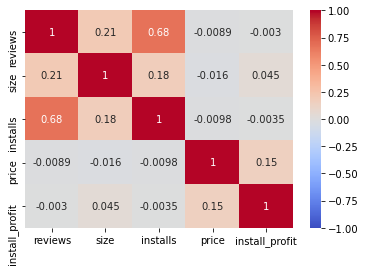

In [34]:
sns.heatmap(data=corr, vmin=-1, cmap='coolwarm', annot=True)
#Some of the predictors are correlated, especially 'installs' and 'reviews' are strongly correlated. 
#Colinearity may exists, linear model is not reliable. With many categorical data, choose random forest method.


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          1975 non-null   int64         
 1   category        1975 non-null   object        
 2   reviews         1975 non-null   int64         
 3   size            1975 non-null   float64       
 4   installs        1975 non-null   int64         
 5   price           1975 non-null   float64       
 6   suitable_for    1975 non-null   object        
 7   last_update     1975 non-null   datetime64[ns]
 8   popularity      1975 non-null   object        
 9   install_profit  1975 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 154.4+ KB


In [36]:
#check relationship among categorical data
csq=chi2_contingency(pd.crosstab(train['category'], train['popularity']))
print("P-value: ",csq[1])
# P value is significant, reject H0 which states category is independent from popularity. 

P-value:  5.485949610118667e-13


In [37]:
csq1=chi2_contingency(pd.crosstab(train['suitable_for'], train['popularity']))
print("P-value: ",csq1[1])
# P value is significant, reject H0 which states suitable_for is independent from popularity. 
# we should include both variables in the model.

P-value:  0.011119715395593536


In [38]:
#Encode category
from sklearn.preprocessing import OneHotEncoder

In [39]:
feature = ['category', 'reviews', 'size', 'installs', 'price',
       'suitable_for', 'install_profit']
categorical_variable=['category','suitable_for']
test_id = test['app_id']
train_y = train['popularity']
train_feature=train[feature]
test_feature = test[feature]


In [40]:
train_feature=pd.get_dummies(train_feature, columns = categorical_variable)
test_feature=pd.get_dummies(test_feature, columns= categorical_variable)

In [61]:
# apply random forest classification:
# evaluate random forest algorithm for classification with cross-validation
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [67]:
rfc = RandomForestClassifier(random_state=434)
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,35,40,45,50],
    'max_features': ['auto'],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [2,3,4],
    'n_estimators': [20,50,100,200,300]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)



In [68]:
grid_search.fit(train_feature, train_y)
grid_search.best_params_

Fitting 4 folds for each of 225 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.0min finished


{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [69]:
best_grid = grid_search.best_estimator_
scores = cross_val_score(best_grid, train_feature, train_y, scoring='accuracy', cv=6, n_jobs=-1)
print(scores)

[0.78181818 0.72340426 0.79635258 0.79331307 0.75987842 0.78115502]


<AxesSubplot:title={'center':'top 10 important features'}>

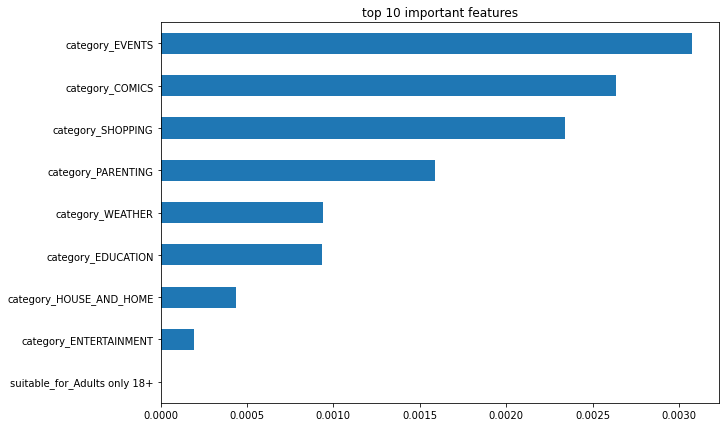

In [92]:
feature_importance=pd.DataFrame(best_grid.feature_importances_.reshape(1,-1),columns=train_feature.columns)
feature_importance.sort_values(by=0,axis=1,inplace=True)
feature_importance.iloc[:,0:9].squeeze(axis=0).plot(kind='barh',title='top 10 important features', figsize=(10,7))

In [95]:
predicted= pd.DataFrame(best_grid.predict(test_feature))
predicted.rename(columns = {0 : 'popularity'}, inplace = True)


In [96]:
predict = pd.concat([pd.DataFrame(test_id),pd.DataFrame(predicted)],axis=1) 

In [97]:
predict

,app_id,popularity
0,144236,High
1,881323,High
2,765524,Low
3,390533,High
4,817383,High
...,...,...
1013,990872,High
1014,850376,High
1015,983504,High
1016,886153,High
